In [67]:
# !pip install arch

In [68]:
#import a whole bunch of stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox




# Data
Let's first import the dataframe we want to work with and manipulate it a bit for easier handling

In [118]:
df= pd.read_csv('data/news_data_2019_2024_sorted.csv')
df.head()
# df.info()

,Date & Time,Headline,Text,Source,News ID,URL,Ticker,Negative Sentiment Score,Neutral Sentiment Score,Positive Sentiment Score,Total Sentiment Score (Compound)
0,2019-03-15 06:46:42-04:00,Did Wells Fargo CEO Tim Sloan Earn His $1 Mill...,We learned this week that the scandal-plagued ...,The Motley Fool,15926,https://www.fool.com/investing/2019/03/14/did-...,WFC,0.000,0.931,0.069,0.2500
1,2019-03-15 06:47:26-04:00,Don't Underestimate Apple's iPhone Business,The segment is an invaluable asset to Apple's ...,The Motley Fool,15927,https://www.fool.com/investing/2019/03/14/dont...,AAPL,0.000,0.748,0.252,0.5248
2,2019-03-15 07:33:00-04:00,A Closer Look At Mastercard's Key Value Drivers,Mastercard has consistently beat street estima...,Forbes,17578,https://www.forbes.com/sites/greatspeculations...,MA,0.060,0.741,0.199,0.7269
3,2019-03-15 07:52:45-04:00,Jim Cramer Gives His Opinion On Bank Of Americ...,"On CNBC's ""Mad Money Lightning Round"", Jim Cra...",Benzinga,16064,https://feeds.benzinga.com/~r/benzinga/~3/Fwtd...,BAC,0.104,0.896,0.000,-0.5367
4,2019-03-15 09:29:39-04:00,Uber And Waymo Seeking Outside Funding For Aut...,Commercially viable autonomous vehicle (AV) te...,Benzinga,15695,https://feeds.benzinga.com/~r/benzinga/~3/fizU...,GOOGL,0.085,0.915,0.000,-0.4201


In [70]:
#which tickers are present
tickers = df['Ticker'].unique()

#change names of columns for ease
new_cols = {'Date & Time': 'Date', 'Negative Sentiment Score': 'Negative_SS', 'Neutral Sentiment Score': 
            'Neutral_SS', 'Positive Sentiment Score': 'Positive_SS', 'Total Sentiment Score (Compound)': 
             'Total_SS' }
df.rename(columns = new_cols, inplace = True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63704 entries, 0 to 63703
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         63704 non-null  object 
 1   Headline     63704 non-null  object 
 2   Text         63704 non-null  object 
 3   Source       63704 non-null  object 
 4   News ID      63704 non-null  int64  
 5   URL          63704 non-null  object 
 6   Ticker       63704 non-null  object 
 7   Negative_SS  63704 non-null  float64
 8   Neutral_SS   63704 non-null  float64
 9   Positive_SS  63704 non-null  float64
 10  Total_SS     63704 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 5.3+ MB



Let's change the date column to datetime objects and remove the time.  

In [71]:
df['New_Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d %H:%M:%S%z', utc = True)

#Only keep the date 
df['New_Date']= df['New_Date'].apply(lambda x: x.date())
df['New_Date'] = pd.to_datetime(df['New_Date'])


/var/folders/tg/nkrt27q937bgzsnrzszxn7bc0000gn/T/ipykernel_2401/2996629266.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['New_Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d %H:%M:%S%z')


For potential future use, let's also make a column that tells us if our total sentiment score is positive, negative, or neutral. For this, I will put a buffer of 
.1 around 0 to indicate neutrality. 

I will use -1, 0, 1 to indicate negative, neutral, and positive respectively. 

In [72]:
def label_sentiment(score:int):
    if score > .1:
        return 1
    elif score < -.1:
        return -1
    else:
        return 0

df['Label_SS'] = df['Total_SS'].apply(lambda x: label_sentiment(x))
df.head()

,Date,Headline,Text,Source,News ID,URL,Ticker,Negative_SS,Neutral_SS,Positive_SS,Total_SS,New_Date,Label_SS
0,2019-03-15 06:46:42-04:00,Did Wells Fargo CEO Tim Sloan Earn His $1 Mill...,We learned this week that the scandal-plagued ...,The Motley Fool,15926,https://www.fool.com/investing/2019/03/14/did-...,WFC,0.000,0.931,0.069,0.2500,2019-03-15,1
1,2019-03-15 06:47:26-04:00,Don't Underestimate Apple's iPhone Business,The segment is an invaluable asset to Apple's ...,The Motley Fool,15927,https://www.fool.com/investing/2019/03/14/dont...,AAPL,0.000,0.748,0.252,0.5248,2019-03-15,1
2,2019-03-15 07:33:00-04:00,A Closer Look At Mastercard's Key Value Drivers,Mastercard has consistently beat street estima...,Forbes,17578,https://www.forbes.com/sites/greatspeculations...,MA,0.060,0.741,0.199,0.7269,2019-03-15,1
3,2019-03-15 07:52:45-04:00,Jim Cramer Gives His Opinion On Bank Of Americ...,"On CNBC's ""Mad Money Lightning Round"", Jim Cra...",Benzinga,16064,https://feeds.benzinga.com/~r/benzinga/~3/Fwtd...,BAC,0.104,0.896,0.000,-0.5367,2019-03-15,-1
4,2019-03-15 09:29:39-04:00,Uber And Waymo Seeking Outside Funding For Aut...,Commercially viable autonomous vehicle (AV) te...,Benzinga,15695,https://feeds.benzinga.com/~r/benzinga/~3/fizU...,GOOGL,0.085,0.915,0.000,-0.4201,2019-03-15,-1


We want to group our data by ticker and date. Here, we just take the naive mean and standard deviation over the days. 

In [73]:
df_mean = df.groupby(['New_Date', 'Ticker'])[['Negative_SS', 'Neutral_SS', 'Positive_SS', 'Total_SS', 'Label_SS']].mean().reset_index()
df_std =df.groupby(['New_Date', 'Ticker'])[['Negative_SS', 'Neutral_SS', 'Positive_SS', 'Total_SS', 'Label_SS']].std().reset_index()
df_mean

#Some dates missing in scoring data. Might be worth looking through to find them 
#The std scores have NANs in them because some days only have one article

,New_Date,Ticker,Negative_SS,Neutral_SS,Positive_SS,Total_SS,Label_SS
0,2019-03-15,AAPL,0.000000,0.799667,0.200333,0.491367,0.666667
1,2019-03-15,AMZN,0.014500,0.810875,0.174625,0.546350,0.875000
2,2019-03-15,BAC,0.104000,0.896000,0.000000,-0.536700,-1.000000
3,2019-03-15,GOOGL,0.042500,0.891500,0.066000,0.087100,0.000000
4,2019-03-15,JPM,0.000000,0.932000,0.068000,0.226300,1.000000
...,...,...,...,...,...,...,...
15412,2024-03-15,MRK,0.135333,0.747667,0.116667,-0.175500,-0.333333
15413,2024-03-15,MSFT,0.034500,0.899500,0.066000,0.219200,0.250000
15414,2024-03-15,NVDA,0.009455,0.881727,0.108727,0.449791,0.636364
15415,2024-03-15,UNH,0.144000,0.719000,0.137000,-0.077200,0.000000


<Axes: xlabel='Total_SS', ylabel='Count'>

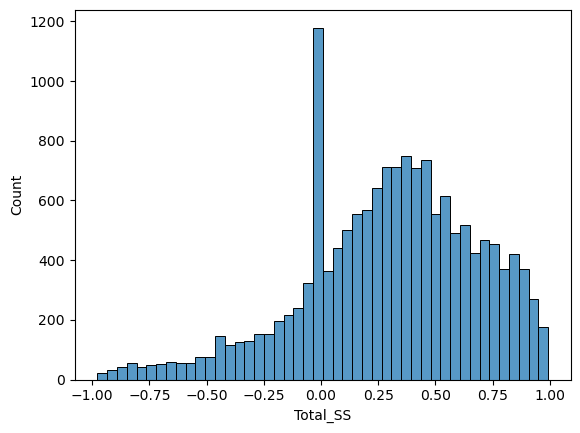

In [115]:
sns.histplot(df_mean['Total_SS'])

<Axes: xlabel='Total_SS', ylabel='Count'>

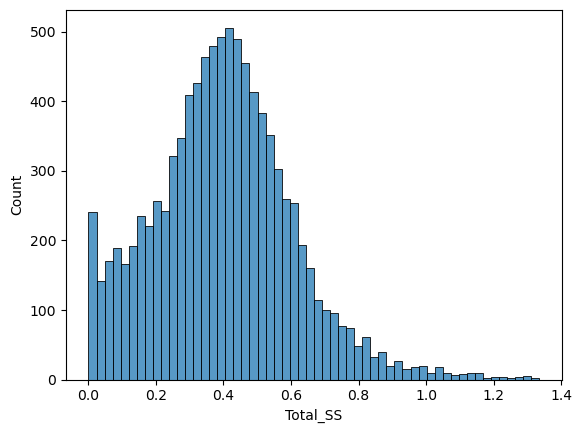

In [116]:
sns.histplot(df_std['Total_SS'])

TBD: Further groupby sector if needed

# Preliminary Graphs
Let's try doing some simple graphs to understand the data a bit more. In this section, we will try to understand the data on the singular stock level. 
The chosen stock for these examples is AAPL, but this can be easily modified. 

Let's start by plotting the date of the article to the total sentiment score. 

WARNING: Graphs are not made pretty, just basic

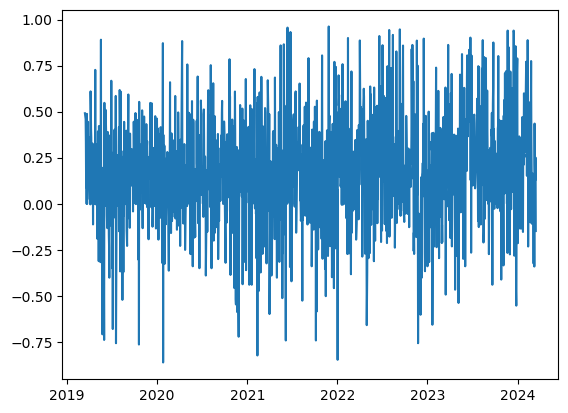

In [74]:
df_aapl = df_mean[df_mean['Ticker'] == 'AAPL'].reset_index()
plt.plot(df_aapl['New_Date'], df_aapl['Total_SS'])

This is pretty messy, and it's a little hard to figure out what is going on here. Let's just zoom into a specific year to see if we can find some patterns.

[]

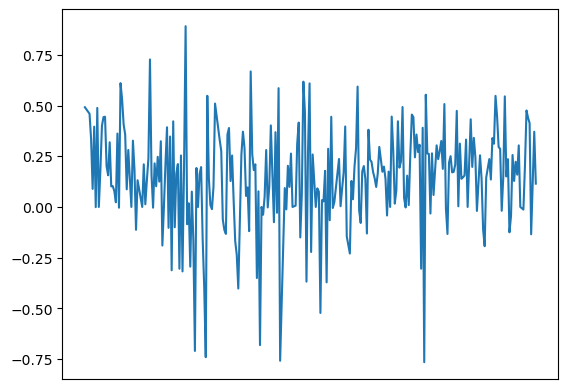

In [75]:
#Note there are missing days in dataset. This returns those missing for our stock
pd.date_range(start = '2019-03-15', end = '2024-03-15' ).difference(df_aapl['New_Date'])

df_aapl_2019 = df_aapl[df_aapl['New_Date'].apply(lambda x: x.year == 2019)]

fig, ax = plt.subplots()
labels = df_aapl_2019['New_Date'].apply(lambda x: (x.month, x.day))

plt.plot(df_aapl_2019['New_Date'], df_aapl_2019['Total_SS'])
ax.set_xticks([])

Not really any better. I guess maybe it's not obvious there would be a pattern in the news. Maybe there are expected highs and lows based on events, such as new Apple product announcements in the fall and spring. 

Let's start looking at autocorrelation factors in our time series to determine if there are time lapse correlations. This seems a little more expected, since one would assume that some news articles being positive or negative might spill over into nearby days. 

This is the Autocorrelation, with default parameters


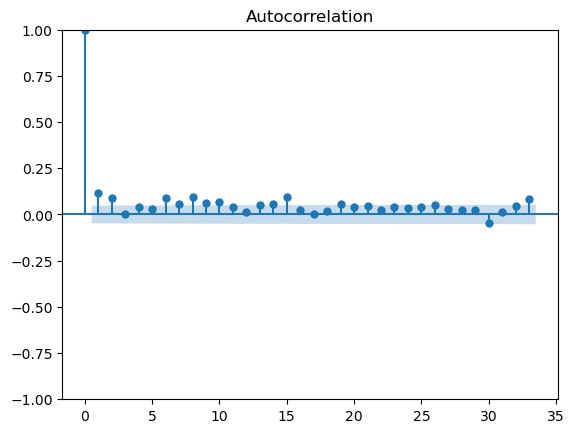

In [76]:
plot_acf(df_aapl['Total_SS'])
print('This is the Autocorrelation, with default parameters')

This is partial Autocorrelation, again with default parameters


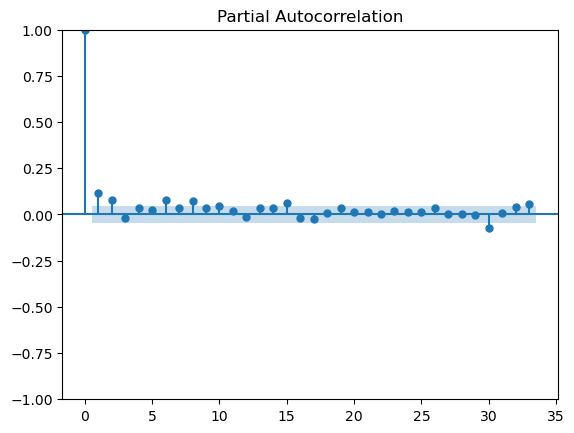

In [77]:
plot_pacf(df_aapl['Total_SS'])
print('This is partial Autocorrelation, again with default parameters')

These graphs seem to indicate that maybe there is some correlation within the first two days, although the second day seems a little suspicious. Would have to vary the stock, and would ideally want to look at stock price as well. For now, a conservative one day lag might be ideal. 

# Simpler Graphs

Let's try to do the graphs again, but this time just look at the labelled sentiment score we defined earlier (i.e. neg, neut, pos). We again use AAPL here.

Because of the way the averaging in the means were done, we should reapply the labelling function.

In [84]:
df_aapl['Label_SS'] = df_aapl['Label_SS'].apply(lambda x: label_sentiment(x))
df_aapl_2019['Label_SS'] = df_aapl_2019['Label_SS'].apply(lambda x: label_sentiment(x))

/var/folders/tg/nkrt27q937bgzsnrzszxn7bc0000gn/T/ipykernel_2401/1255165724.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aapl_2019['Label_SS'] = df_aapl_2019['Label_SS'].apply(lambda x: label_sentiment(x))


([], [])

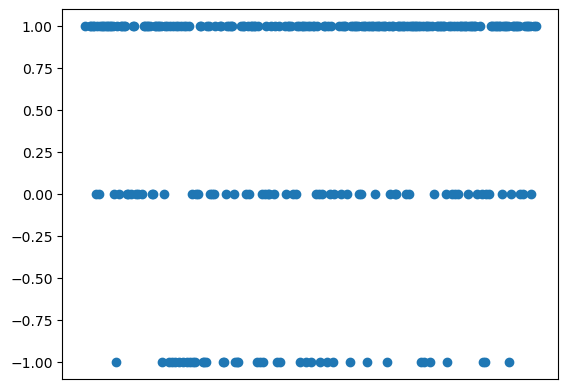

In [85]:
plt.scatter(df_aapl_2019['New_Date'], df_aapl_2019['Label_SS'])
plt.xticks([])

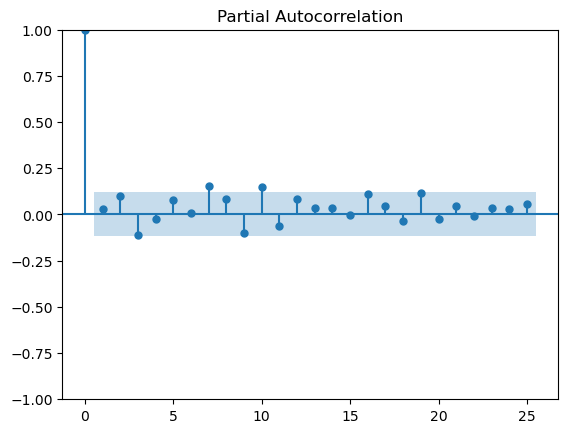

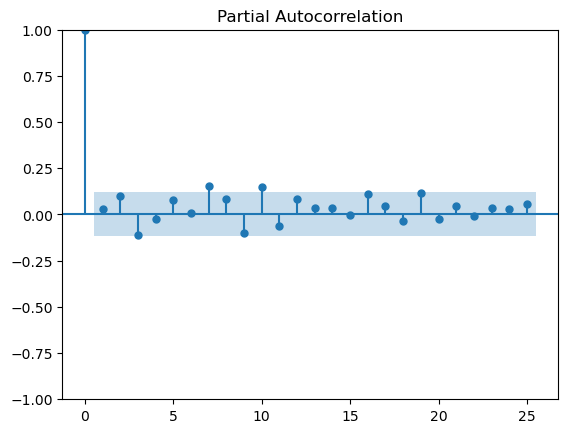

In [86]:
plot_pacf(df_aapl_2019['Label_SS'])

... Maybe not useful... Maybe this section should be revisited or removed in the future.

For now, maybe length of positive, negative, and neutrals might be better

In [90]:
label_data_date= df.groupby(['New_Date', 'Ticker'])['Label_SS'].value_counts()
label_data = df.groupby(['Ticker'])['Label_SS'].value_counts()
label_data

Ticker  Label_SS
AAPL     1           6707
        -1           3372
         0           2912
ABBV     1            924
        -1            317
         0            211
AMZN     1          10567
        -1           2407
         0           1055
BAC      1           1160
        -1            308
         0            289
GOOGL    1           4301
        -1           2348
         0           1667
JNJ      1           1135
        -1            627
         0            451
JPM      1           1522
        -1            567
         0            419
LLY      1           1023
        -1            355
         0            315
MA       1           1096
         0            277
        -1            139
MRK      1            903
        -1            430
         0            369
MSFT     1           3749
         0           1138
        -1           1047
NVDA     1           3428
         0            941
        -1            810
UNH      1            786
         0           

Is there interesting trends here? Is positive news much more common than negative news, for instance? 
Let's just compute positivity rates. 

In [114]:
positivity_rates = {}
for tick in tickers:
    positivity_rates[tick] = label_data[(tick, 1)] / (label_data[tick, 1]+label_data[tick, 0]+label_data[tick, -1])
positivity_rates


{'WFC': 0.7988950276243094,
 'AAPL': 0.516280501885921,
 'MA': 0.7248677248677249,
 'BAC': 0.6602162777461582,
 'GOOGL': 0.5171957671957672,
 'AMZN': 0.7532254615439447,
 'JPM': 0.6068580542264753,
 'MSFT': 0.6317829457364341,
 'V': 0.72674791533034,
 'ABBV': 0.6363636363636364,
 'NVDA': 0.6619038424406256,
 'LLY': 0.6042528056704075,
 'MRK': 0.5305522914218567,
 'UNH': 0.7492850333651097,
 'JNJ': 0.5128784455490285}

Seems the answer is yes, with the least positive being AAPL and JNJ. 

# Moving Averages

Perhaps we want to compute the data with moving averages. We can do both non-weighted and weighted rolling averages. 

Some Questions:
How much should we move by? 
How much should we weigh by?

In [ ]:
#Maybe a week, a month, and 6 months 

# Other Questions to Consider

Should we examine news sites a bit better? Possible some sites use give out more positive articles than others. This is perhaps too complicated for the current project, might be a good future direction (Related to finding which sites have most influence over stock prices)

Find outliers in the mean data, see if these news sources have more affect on the stock prices 